# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import folium
from folium.plugins import HeatMap
import plotly.express as px

plt.style.use('fivethirtyeight')
%matplotlib inline
pd.set_option('display.max_columns', 32)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

In [10]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


### DATA ANALYSIS

How many of the Bookings are complete?





Text(0.5, 1.0, 'Classification of Booking')

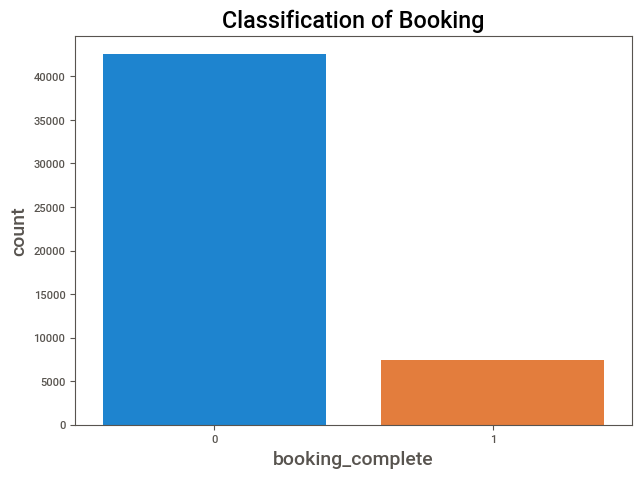

In [85]:

sns.countplot(data=df, x ='booking_complete')
plt.title('Classification of Booking')

In [86]:
df['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

What are the trip types and how

<Axes: xlabel='trip_type', ylabel='count'>

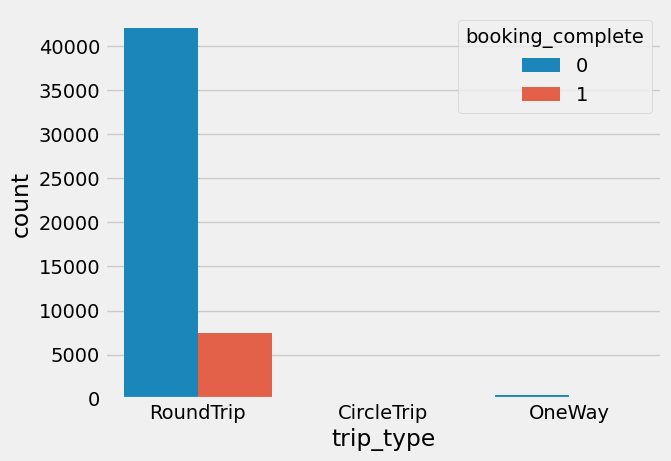

In [12]:
sns.countplot(data=df, x ='trip_type', hue='booking_complete')

What Channel is the ticket gotten?

<Axes: ylabel='sales_channel'>

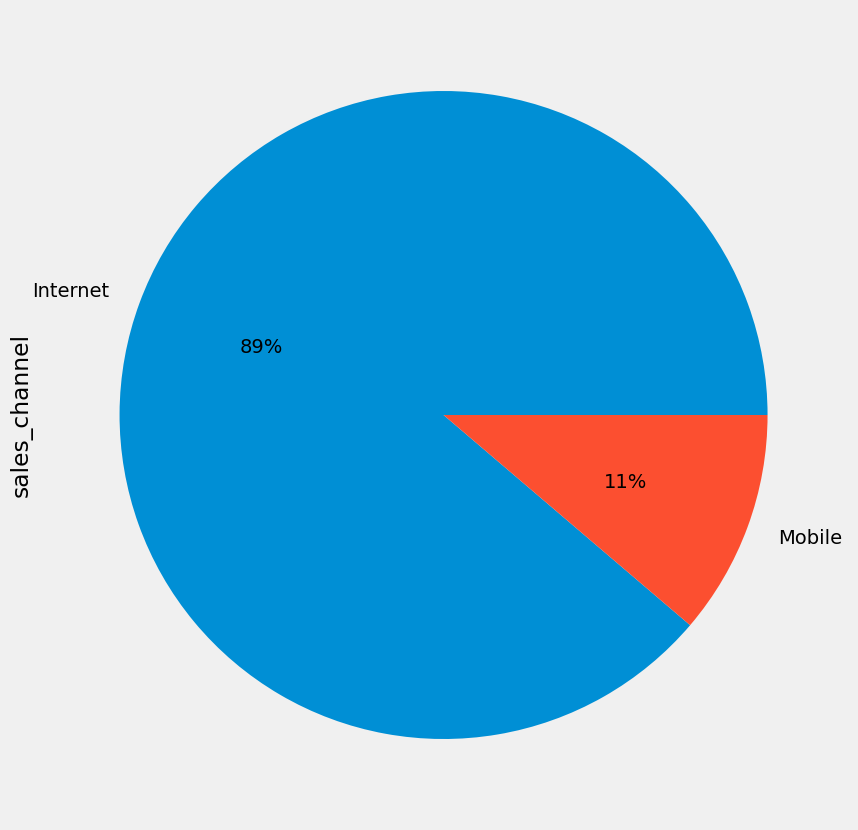

In [13]:
df['sales_channel'].value_counts().plot(kind='pie',autopct ='%.0f%%',figsize=(10,10))

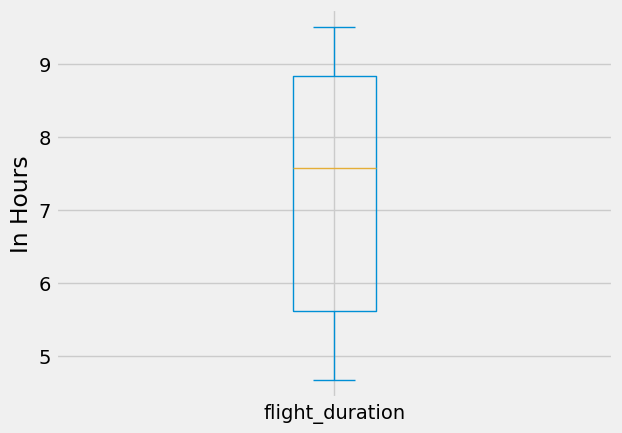

In [16]:
#creating a box plot
df['flight_duration'].plot(kind ='box')
plt.ylabel('In Hours');

Text(0, 0.5, 'Number of Bookings')

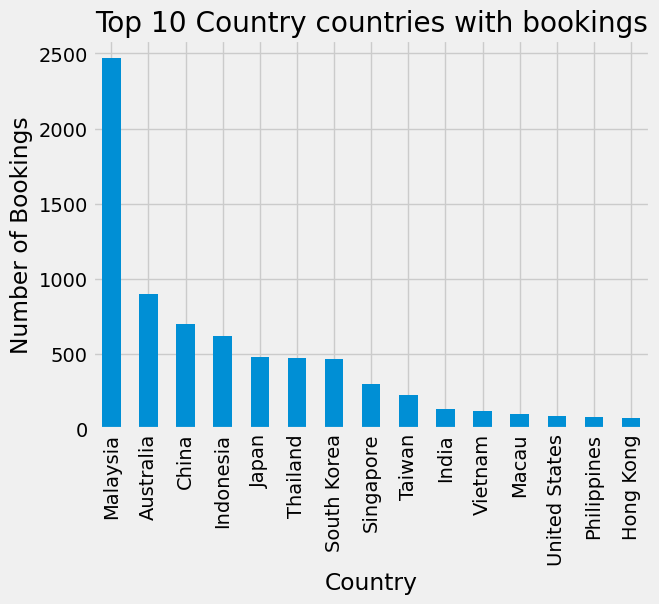

In [18]:
#Top 10 Country countries with bookings

df[df['booking_complete'] == 1]['booking_origin'].value_counts().sort_values(ascending=False)[0:15].plot(kind ='bar')

plt.title('Top 10 Country countries with bookings')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')

In [19]:
country = df[df['booking_complete'] == 1]['booking_origin'].value_counts().reset_index()
country.columns = ['booking_origin', 'No of bookings']
country

,booking_origin,No of bookings
0,Malaysia,2468
1,Australia,900
2,China,694
3,Indonesia,615
4,Japan,478
5,Thailand,470
6,South Korea,462
7,Singapore,299
8,Taiwan,224
9,India,131


In [22]:
basemap = folium.Map()
guests_map = px.choropleth(country, locations = country['booking_origin'],
                           color = country['No of bookings'], hover_name = country['booking_origin'])
guests_map.show()


In [23]:
df['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [24]:
# checking for null values

null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
null

,Null Values,Percentage Null Values
num_passengers,0,0.0
sales_channel,0,0.0
trip_type,0,0.0
purchase_lead,0,0.0
length_of_stay,0,0.0
flight_hour,0,0.0
flight_day,0,0.0
route,0,0.0
booking_origin,0,0.0
wants_extra_baggage,0,0.0


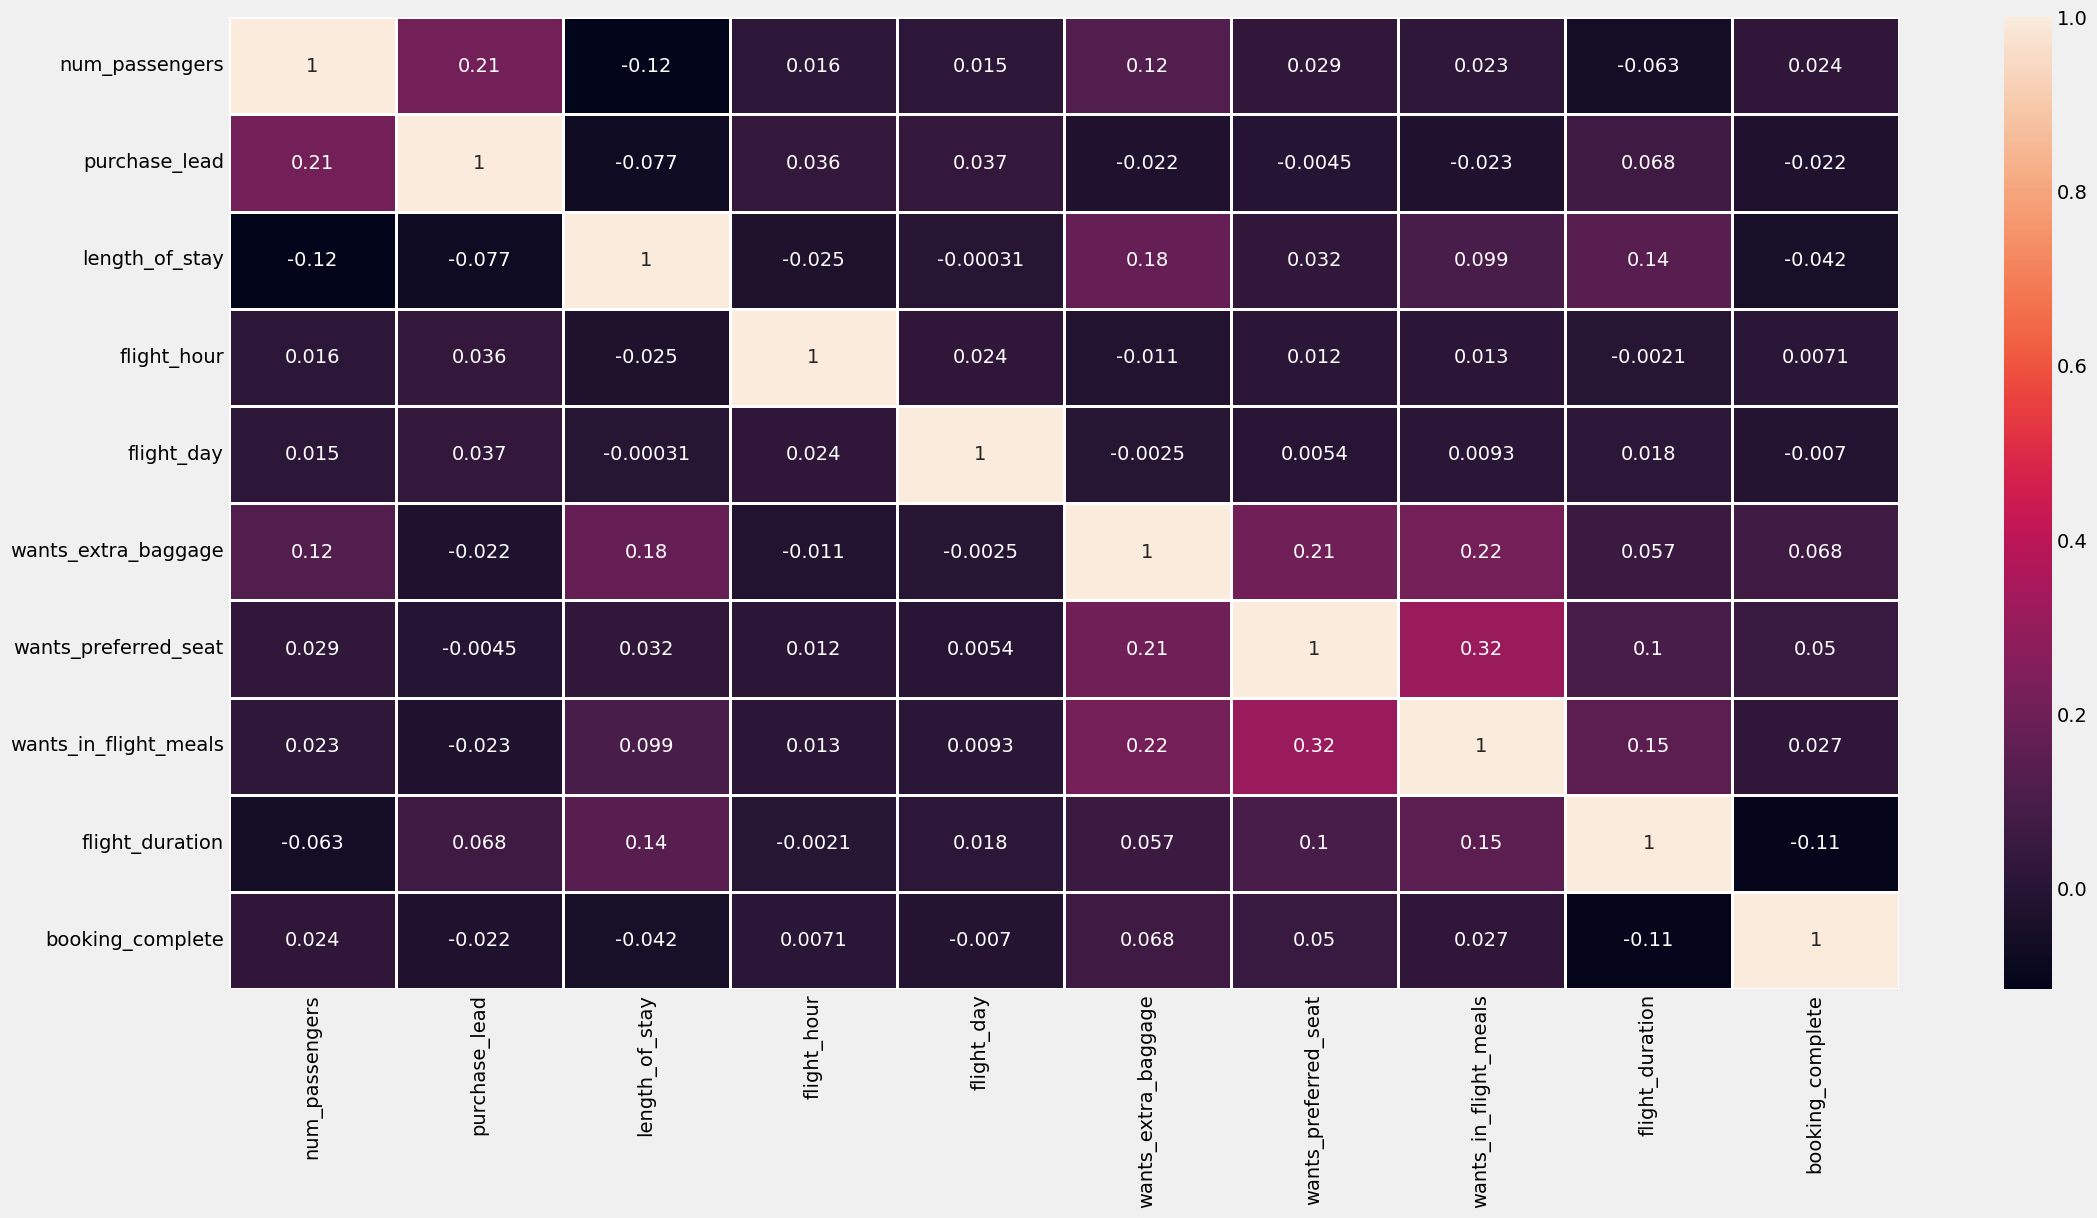

In [25]:
plt.figure(figsize = (24, 12))

corr = df.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [26]:
correlation = df.corr()['booking_complete'].abs().sort_values(ascending = False)
correlation

booking_complete         1.000000
flight_duration          0.106266
wants_extra_baggage      0.068139
wants_preferred_seat     0.050116
length_of_stay           0.042408
wants_in_flight_meals    0.026511
num_passengers           0.024116
purchase_lead            0.022131
flight_hour              0.007127
flight_day               0.006986
Name: booking_complete, dtype: float64

In [32]:
#dropping columns that are not useful

useless_col = ['booking_origin','route',"sales_channel"]

df.drop(useless_col, axis = 1, inplace = True)

KeyError: ignored

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   trip_type              50000 non-null  object 
 2   purchase_lead          50000 non-null  int64  
 3   length_of_stay         50000 non-null  int64  
 4   flight_hour            50000 non-null  int64  
 5   flight_day             50000 non-null  int64  
 6   wants_extra_baggage    50000 non-null  int64  
 7   wants_preferred_seat   50000 non-null  int64  
 8   wants_in_flight_meals  50000 non-null  int64  
 9   flight_duration        50000 non-null  float64
 10  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 4.2+ MB


In [34]:
# creating numerical and categorical dataframes

cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['trip_type']

In [35]:
cat_df = df[cat_cols]
cat_df.head()

,trip_type
0,RoundTrip
1,RoundTrip
2,RoundTrip
3,RoundTrip
4,RoundTrip


In [36]:
# printing unique values of each column
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

trip_type: 
['RoundTrip' 'CircleTrip' 'OneWay']



In [37]:
# encoding categorical variables

cat_df['trip_type'] = cat_df['trip_type'].map({'RoundTrip' : 0, 'CircleTrip' : 1,'OneWay':2})

In [38]:
cat_df

,trip_type
0,0
1,0
2,0
3,0
4,0
...,...
49995,0
49996,0
49997,0
49998,0


In [39]:
num_df = df.drop(columns = cat_cols, axis = 1)

num_df

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,262,19,7,6,1,0,0,5.52,0
1,1,112,20,3,6,0,0,0,5.52,0
2,2,243,22,17,3,1,1,0,5.52,0
3,1,96,31,4,6,0,0,1,5.52,0
4,2,68,22,15,3,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,6,1,0,1,5.62,0
49996,1,111,6,4,7,0,0,0,5.62,0
49997,1,24,6,22,6,0,0,1,5.62,0
49998,1,15,6,11,1,1,0,1,5.62,0


In [40]:
num_df.var()

num_passengers              1.040736
purchase_lead            8181.451806
length_of_stay           1148.374182
flight_hour                29.296885
flight_day                  3.971219
wants_extra_baggage         0.221518
wants_preferred_seat        0.208779
wants_in_flight_meals       0.244696
flight_duration             2.240599
booking_complete            0.127194
dtype: float64

In [41]:
# normalizing numerical variables

#num_df['purchase_lead'] = np.log(num_df['purchase_lead'] + 1)
#num_df['length_of_stay'] = np.log(num_df['length_of_stay'] + 1)
#num_df['flight_hour'] = np.log(num_df['flight_hour'] + 1)
#num_df.var()


In [42]:
X = pd.concat([cat_df, num_df], axis = 1)
y = df['booking_complete']

In [43]:
X.head()

,trip_type,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0,2,262,19,7,6,1,0,0,5.52,0
1,0,1,112,20,3,6,0,0,0,5.52,0
2,0,2,243,22,17,3,1,1,0,5.52,0
3,0,1,96,31,4,6,0,0,1,5.52,0
4,0,2,68,22,15,3,1,0,1,5.52,0


In [44]:
complete = X[X["booking_complete"] == 1]
incomplete = X[X["booking_complete"] == 0]

In [ ]:
complete.shape,incomplete.shape

((7478, 11), (42522, 11))

In [45]:
from sklearn.utils import resample
complete_upsample = resample(complete,
             replace=True,
             n_samples=len(incomplete),
             random_state=42)

print(complete_upsample.shape)

(42522, 11)


1    42522
0    42522
Name: booking_complete, dtype: int64


<Axes: ylabel='Type'>

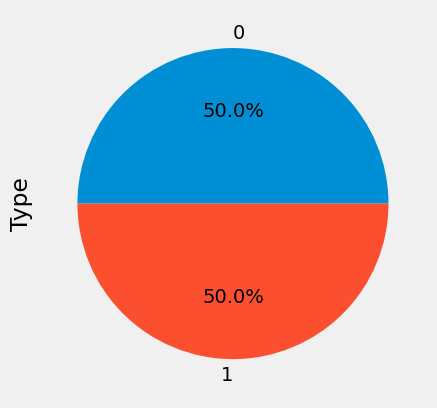

In [46]:
data_downsampled = pd.concat([complete_upsample, incomplete])

print(data_downsampled["booking_complete"].value_counts())

data_downsampled.groupby('booking_complete').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [47]:
y = data_downsampled['booking_complete']
data_downsampled.drop('booking_complete', axis = 1, inplace = True)


In [48]:
X=data_downsampled

In [49]:
X.shape, y.shape

((85044, 10), (85044,))

In [52]:
# splitting data into training set and test set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

Logistic Regression

In [53]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression is : 0.5927450173437592
Confusion Matrix : 
[[5283 3352]
 [3575 4799]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      8635
           1       0.59      0.57      0.58      8374

    accuracy                           0.59     17009
   macro avg       0.59      0.59      0.59     17009
weighted avg       0.59      0.59      0.59     17009



KNN

In [54]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
conf = confusion_matrix(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of KNN is : 0.7764712799106356
Confusion Matrix : 
[[5505 3130]
 [ 672 7702]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.64      0.74      8635
           1       0.71      0.92      0.80      8374

    accuracy                           0.78     17009
   macro avg       0.80      0.78      0.77     17009
weighted avg       0.80      0.78      0.77     17009



DECISION tREE


In [55]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree is : 0.9163972014815686
Confusion Matrix : 
[[7272 1363]
 [  59 8315]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      8635
           1       0.86      0.99      0.92      8374

    accuracy                           0.92     17009
   macro avg       0.93      0.92      0.92     17009
weighted avg       0.93      0.92      0.92     17009



RANDOM FOREST

In [56]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Random Forest is : 0.9616673525780469
Confusion Matrix : 
[[8047  588]
 [  64 8310]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      8635
           1       0.93      0.99      0.96      8374

    accuracy                           0.96     17009
   macro avg       0.96      0.96      0.96     17009
weighted avg       0.96      0.96      0.96     17009



Ada Boost Classifier

In [57]:
ada = AdaBoostClassifier(base_estimator = dtc)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred_ada)
conf = confusion_matrix(y_test, y_pred_ada)
clf_report = classification_report(y_test, y_pred_ada)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_ada}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.863895584690458
Confusion Matrix : 
[[6371 2264]
 [  51 8323]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      8635
           1       0.79      0.99      0.88      8374

    accuracy                           0.86     17009
   macro avg       0.89      0.87      0.86     17009
weighted avg       0.89      0.86      0.86     17009



Gradient Boosting Classifier

In [58]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
conf = confusion_matrix(y_test, y_pred_gb)
clf_report = classification_report(y_test, y_pred_gb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_gb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.6440119936504204
Confusion Matrix : 
[[5684 2951]
 [3104 5270]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.65      0.66      0.65      8635
           1       0.64      0.63      0.64      8374

    accuracy                           0.64     17009
   macro avg       0.64      0.64      0.64     17009
weighted avg       0.64      0.64      0.64     17009



XgBoost Classifier

In [59]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
conf = confusion_matrix(y_test, y_pred_xgb)
clf_report = classification_report(y_test, y_pred_xgb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_xgb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.6820506790522665
Confusion Matrix : 
[[5751 2884]
 [2524 5850]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      8635
           1       0.67      0.70      0.68      8374

    accuracy                           0.68     17009
   macro avg       0.68      0.68      0.68     17009
weighted avg       0.68      0.68      0.68     17009



Cat Boost Classifier

In [60]:
cat = CatBoostClassifier(iterations=100)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)
print(f"Accuracy Score of Cat Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Learning rate set to 0.5
0:	learn: 0.6635728	total: 54.3ms	remaining: 5.38s
1:	learn: 0.6507211	total: 60.6ms	remaining: 2.97s
2:	learn: 0.6465113	total: 66.6ms	remaining: 2.15s
3:	learn: 0.6422514	total: 73.6ms	remaining: 1.77s
4:	learn: 0.6400847	total: 80.3ms	remaining: 1.52s
5:	learn: 0.6383668	total: 86.1ms	remaining: 1.35s
6:	learn: 0.6365003	total: 92.2ms	remaining: 1.22s
7:	learn: 0.6351353	total: 98.1ms	remaining: 1.13s
8:	learn: 0.6340826	total: 104ms	remaining: 1.05s
9:	learn: 0.6324589	total: 110ms	remaining: 990ms
10:	learn: 0.6319564	total: 115ms	remaining: 931ms
11:	learn: 0.6307271	total: 121ms	remaining: 888ms
12:	learn: 0.6293646	total: 127ms	remaining: 850ms
13:	learn: 0.6290689	total: 132ms	remaining: 811ms
14:	learn: 0.6284301	total: 138ms	remaining: 784ms
15:	learn: 0.6273385	total: 154ms	remaining: 808ms
16:	learn: 0.6268559	total: 160ms	remaining: 781ms
17:	learn: 0.6258526	total: 166ms	remaining: 757ms
18:	learn: 0.6253389	total: 172ms	remaining: 733ms
19:	lear

Extra Trees Classifier

In [61]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

y_pred_etc = etc.predict(X_test)

acc_etc = accuracy_score(y_test, y_pred_etc)
conf = confusion_matrix(y_test, y_pred_etc)
clf_report = classification_report(y_test, y_pred_etc)

print(f"Accuracy Score of Extra Trees Classifier is : {acc_etc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

Accuracy Score of Extra Trees Classifier is : 0.974601681462755
Confusion Matrix : 
[[8270  365]
 [  67 8307]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      8635
           1       0.96      0.99      0.97      8374

    accuracy                           0.97     17009
   macro avg       0.97      0.97      0.97     17009
weighted avg       0.98      0.97      0.97     17009



LGBM Classifier

In [70]:
lgbm = LGBMClassifier(learning_rate = 0.905)
lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
conf = confusion_matrix(y_test, y_pred_lgbm)
clf_report = classification_report(y_test, y_pred_lgbm)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_lgbm}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.762302310541478
Confusion Matrix : 
[[6102 2533]
 [1510 6864]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      8635
           1       0.73      0.82      0.77      8374

    accuracy                           0.76     17009
   macro avg       0.77      0.76      0.76     17009
weighted avg       0.77      0.76      0.76     17009



Voting Classifier

In [71]:
classifiers = [('Gradient Boosting Classifier', gb), ('Cat Boost Classifier', cat), ('XGboost', xgb),  ('Decision Tree', dtc),
               ('Extra Tree', etc), ('Light Gradient', lgbm), ('Random Forest', rd_clf), ('Ada Boost', ada), ('Logistic', lr),
               ('Knn', knn)]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.6635728	total: 7.26ms	remaining: 719ms
1:	learn: 0.6507211	total: 13.5ms	remaining: 662ms
2:	learn: 0.6465113	total: 19.5ms	remaining: 630ms
3:	learn: 0.6422514	total: 25.6ms	remaining: 614ms
4:	learn: 0.6400847	total: 32.1ms	remaining: 611ms
5:	learn: 0.6383668	total: 38.1ms	remaining: 597ms
6:	learn: 0.6365003	total: 44.5ms	remaining: 592ms
7:	learn: 0.6351353	total: 50.6ms	remaining: 582ms
8:	learn: 0.6340826	total: 56.4ms	remaining: 570ms
9:	learn: 0.6324589	total: 62.8ms	remaining: 565ms
10:	learn: 0.6319564	total: 68.3ms	remaining: 553ms
11:	learn: 0.6307271	total: 75.9ms	remaining: 557ms
12:	learn: 0.6293646	total: 82.4ms	remaining: 551ms
13:	learn: 0.6290689	total: 89.1ms	remaining: 547ms
14:	learn: 0.6284301	total: 95.3ms	remaining: 540ms
15:	learn: 0.6273385	total: 102ms	remaining: 537ms
16:	learn: 0.6268559	total: 108ms	remaining: 528ms
17:	learn: 0.6258526	total: 114ms	remaining: 522ms
18:	learn: 0.6253389	total: 121ms	remaining: 514ms
1

VotingClassifier(estimators=[('Gradient Boosting Classifier',
                              GradientBoostingClassifier()),
                             ('Cat Boost Classifier',
                              <catboost.core.CatBoostClassifier object at 0x7f940575e500>),
                             ('XGboost',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categor...
                                            predictor=None, random_state=None, ...)),
                             ('Decision Tree', DecisionTreeClassifier()),
                             ('Extra Tree', ExtraTreesClassifier()),
                             ('Light Gradient',
                              LGBMClassifier(learning_rate=0.905)),
                             ('Random Forest', RandomForestClassifier()),
                             ('Ada Boost',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier())),
                             ('Logistic', LogisticRegression()),
                             ('Knn', KNeighborsClassifier())])

In [72]:
y_pred_vc = vc.predict(X_test)

acc_vtc = accuracy_score(y_test, y_pred_vc)
conf = confusion_matrix(y_test, y_pred_vc)
clf_report = classification_report(y_test, y_pred_vc)

print(f"Accuracy Score of Voting Classifier is : {acc_vtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Voting Classifier is : 0.8676582985478276
Confusion Matrix : 
[[7270 1365]
 [ 886 7488]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      8635
           1       0.85      0.89      0.87      8374

    accuracy                           0.87     17009
   macro avg       0.87      0.87      0.87     17009
weighted avg       0.87      0.87      0.87     17009



Artificial Neural Network

In [73]:
from tensorflow.keras.utils import to_categorical

X=data_downsampled
y = to_categorical(y)

In [74]:
# splitting data into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [75]:
X_train.shape

(59530, 10)

In [76]:
import keras
from keras.layers import Dense
from keras.models import Sequential

model  = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (10, )))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
                          epochs = 100)

Epoch 1/100
1861/1861 [==============================] - 4s 2ms/step - loss: 0.7211 - accuracy: 0.5746 - val_loss: 0.7474 - val_accuracy: 0.5650
Epoch 2/100
1861/1861 [==============================] - 4s 2ms/step - loss: 0.6806 - accuracy: 0.5973 - val_loss: 0.6707 - val_accuracy: 0.5958
Epoch 3/100
1861/1861 [==============================] - 4s 2ms/step - loss: 0.6706 - accuracy: 0.6037 - val_loss: 0.6628 - val_accuracy: 0.6076
Epoch 4/100
1861/1861 [==============================] - 4s 2ms/step - loss: 0.6649 - accuracy: 0.6069 - val_loss: 0.6661 - val_accuracy: 0.6114
Epoch 5/100
1861/1861 [==============================] - 3s 2ms/step - loss: 0.6622 - accuracy: 0.6085 - val_loss: 0.6660 - val_accuracy: 0.6025
Epoch 6/100
1861/1861 [==============================] - 3s 2ms/step - loss: 0.6594 - accuracy: 0.6103 - val_loss: 0.6743 - val_accuracy: 0.6011
Epoch 7/100
1861/1861 [==============================] - 3s 2ms/step - loss: 0.6578 - accuracy: 0.6114 - val_loss: 0.6588 - val_ac

In [77]:
plt.figure(figsize = (12, 6))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epoch = range(1, 101)

loss = pd.DataFrame({'train_loss' : train_loss, 'val_loss' : val_loss})

px.line(data_frame = loss, x = epoch, y = ['val_loss', 'train_loss'], title = 'Training and Validation Loss',
        template = 'plotly_dark')

<Figure size 1200x600 with 0 Axes>

In [78]:
plt.figure(figsize = (12, 6))

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epoch = range(1, 101)


accuracy = pd.DataFrame({'train_acc' : train_acc, 'val_acc' : val_acc})

px.line(data_frame = accuracy, x = epoch, y = ['val_acc', 'train_acc'], title = 'Training and Validation Accuracy',
        template = 'plotly_dark')

<Figure size 1200x600 with 0 Axes>

In [80]:
acc_ann = model.evaluate(X_test, y_test)[1]

print(f'Accuracy of model is {acc_ann}')

798/798 [==============================] - 1s 980us/step - loss: 0.6224 - accuracy: 0.6623
Accuracy of model is 0.6623422503471375


Models Comparison

In [81]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'Voting Classifier'
               , 'ANN'],
    'Score' : [acc_lr, acc_knn, acc_dtc, acc_rd_clf, acc_ada, acc_gb, acc_xgb, acc_cat, acc_etc, acc_lgbm, acc_vtc, acc_ann]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
8,Extra Trees Classifier,0.974602
3,Random Forest Classifier,0.961667
2,Decision Tree Classifier,0.916397
10,Voting Classifier,0.867658
4,Ada Boost Classifier,0.863896
1,KNN,0.776471
9,LGBM,0.762302
6,XgBoost,0.682051
7,Cat Boost,0.678876
11,ANN,0.662342


In [82]:
px.bar(data_frame = models, x = 'Score', y = 'Model', color = 'Score', template = 'plotly_dark', title = 'Models Comparison')